In [1]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
import networkit as nk
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

## Generation of graph
### generatePowerlawCommunitySizeSequence()
Generate a powerlaw community size sequence with the given minimum and maximum size and the given exponent.
    Parameters:	
        - minCommunitySize (count) – The minimum community size
        - maxCommunitySize (count) – The maximum community size
        - communitySizeExp (double) – The (negative) community size exponent of the power law degree distribution of the community sizes

### generatePowerlawDegreeSequence()
Generate and set a power law degree sequence using the given average and maximum degree with the given exponent.
    Parameters:	
        - avgDegree (count) – The average degree of the created graph
        - maxDegree (count) – The maximum degree of the created graph
        - nodeDegreeExp (double) – The (negative) exponent of the power law degree distribution of the node degrees

### setMu()
Set the mixing parameter, this is the fraction of neighbors of each node that do not belong to the node’s own community. This can either be one value for all nodes or an iterable of values for each node.
    Parameters:
        - mu (double or collections.Iterable) – The mixing coefficient(s), i.e. the factor of the degree that shall be inter-cluster degree

In [10]:
generator = nk.generators.LFRGenerator(5000)
generator.generatePowerlawCommunitySizeSequence(minCommunitySize=20, maxCommunitySize=50, communitySizeExp=-1)
generator.generatePowerlawDegreeSequence(avgDegree=15, maxDegree=50, nodeDegreeExp=-2)
generator.setMu(0.4)
generator.run()
G, gt_partition = generator.getGraph(), generator.getPartition()
nk.overview(G)
nk.community.inspectCommunities(gt_partition, G)
print(f"{gt_partition.numberOfSubsets()} community detected")

Network Properties for:		G#167
nodes, edges			5000, 38293
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.003064
clustering coefficient		0.166303
min/max/avg degree		7, 50, 15.317200
degree assortativity		-0.135295
number of connected components	1
size of largest component	5000 (100.00 %)
-------------------  ----------
# communities        153
min community size    20
max community size    55
avg. community size   32.6797
modularity             0.575536
-------------------  ----------
153 community detected


## Compute Training and testing sets

In [3]:
edges = G.edges()
deg_min, deg_max, clust_min, clust_max = [], [], [], []
features = ["deg_min", "deg_max", "clust_min", "clust_max"]
inside = []
cc = nk.centrality.LocalClusteringCoefficient(G).run().scores()

for (u, v) in edges:
    degU, degV = G.degree(u), G.degree(v)
    clustU, clustV = cc[u], cc[v]

    deg_min.append(min(degU, degV))
    deg_max.append(max(degU, degV))
    clust_min.append(min(clustU, clustV))
    clust_max.append(max(clustU, clustV))

    if gt_partition.subsetOf(u) == gt_partition.subsetOf(v):
        inside.append(1)
    else:
        inside.append(0)

X = np.array([deg_min, deg_max, clust_min, clust_max])
Y = inside
X = X.transpose()
samples, nb_features = X.shape
Xtest, Xtrain, Ytest, Ytrain = train_test_split(X, Y, test_size=0.4)

In [7]:
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(Xtrain, Ytrain)

## Test on same graph

In [8]:
predictions = gbm.predict(Xtest)
confidence = gbm.predict_proba(Xtest)
print(metrics.classification_report(Ytest, predictions))
mat = metrics.confusion_matrix(Ytest, predictions)
# print("Confusion matrix:")
# print(mat)
prec, rec, fmeasure, support = metrics.precision_recall_fscore_support(Ytest, predictions)

              precision    recall  f1-score   support

           0       0.63      0.31      0.41      9542
           1       0.64      0.87      0.73     13288

   micro avg       0.63      0.63      0.63     22830
   macro avg       0.63      0.59      0.57     22830
weighted avg       0.63      0.63      0.60     22830



### Observe Classifier

['deg_min', 'deg_max', 'clust_min', 'clust_max']


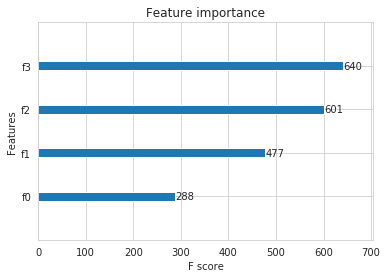

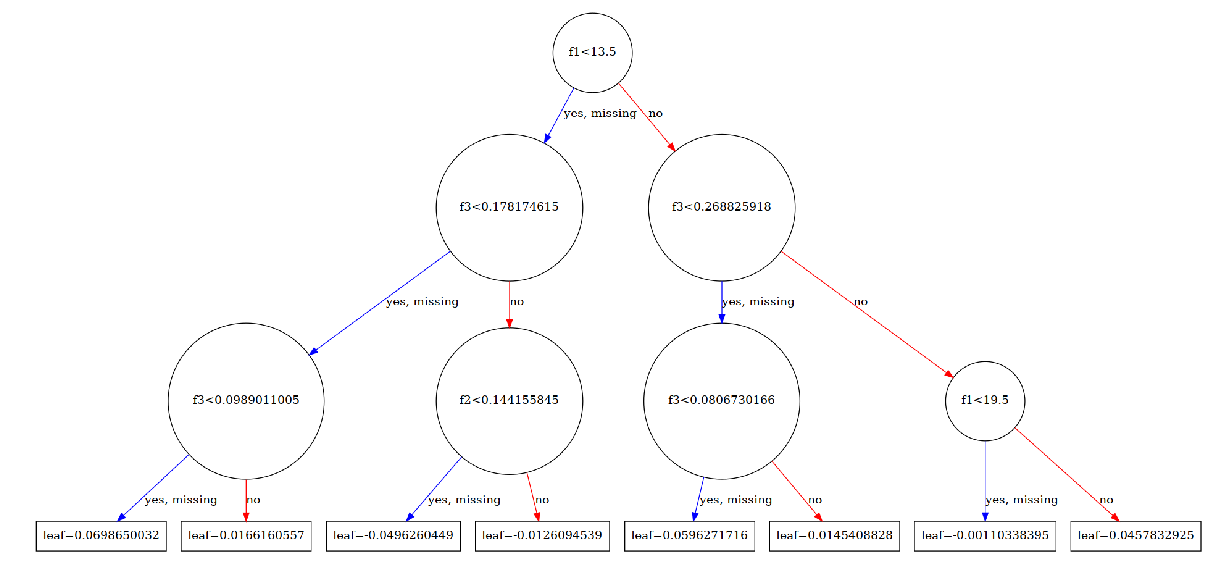

In [9]:
print(features)
xgb.plot_importance(gbm)
xgb.plot_tree(gbm, num_trees=2)
fig = plt.gcf()
fig.set_size_inches(25, 10)

# TODO
- Plot on bar recall, precision, support, fmeasure by nature of link
- Error rate depending on confidence
- Try to find a correlation beetween link property and error rate

## Observe results